In [1]:
##############
## input: input-run-MTR_*.csv
## output: combined_scRNA_seq_data.h5ad, combined_scRNA_seq_data_39X.h5ad
##############

# 1. Environment

In [2]:
import os
import re
import csv
import glob
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from functools import partial
from concurrent.futures import ProcessPoolExecutor, as_completed

In [3]:
output_dir = "/group/testa/Project/EndPoints/scRNASeq/preAnalysis/output"

meta_dir = "/group/testa/Project/EndPoints/2024_singleCell/nextflow/output/cellranger-multi"
data_dir = "/group/testa/Project/EndPoints/2024_singleCell/nextflow/output/cellranger-multi/filtered_matrix"        
classification_dir = '/group/testa/Project/EndPoints/2024_singleCell/multiseq/classification'                      
cmo_dir = "/group/testa/Project/EndPoints/scRNASeq/preAnalysis/"

In [ ]:
def load_csv_files(classification_dir):
    # Get a list of all CSV files in the directory
    csv_files = glob.glob(os.path.join(classification_dir, '*_multiseq_class.csv'))
    
    dataframes = {}
    
    for file in csv_files:
        # Extract the file name without extension
        file_name = os.path.basename(file).split('.')[0]
        
        # Extract the run number
        run_number = file_name.split('_')[0]
        
        # Create the run name (e.g., run_491)
        run_name = f"run_{run_number}"
        
        df = pd.read_csv(file, sep='\t')
        
        dataframes[run_name] = df
    
    return dataframes

In [ ]:
def extract_condition_type(file_path):
    condition = []
    line = []
    replicate = []
    cmo = []

    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        in_samples_section = False
        
        for row in csv_reader:
            if row and row[0] == 'sample_id':
                in_samples_section = True
                continue
            
            if in_samples_section and row:
                condition_and_line_and_replicate = row[0]
                parts = condition_and_line_and_replicate.split('_')
                
                condition.append('_'.join(parts[:-2]))
                line.append(parts[-2])
                replicate.append(parts[-1])
                cmo.append(row[1])
    
    return [condition, line, replicate, cmo]

In [ ]:
def process_run(run_dir):
    try:
        adata = sc.read_h5ad(os.path.join(run_dir, 'matrix.h5ad'))
        run_name = os.path.basename(run_dir).split('_')[-1]
        
        adata.obs["run"] = run_name
        adata.obs = adata.obs.reset_index().rename(columns={'index': 'tags'})
        adata.obs['index'] = adata.obs['tags'].astype(str) + '-' + adata.obs['run']
        adata.obs.set_index('index', inplace=True)
        adata.var_names_make_unique()
        adata.obs_names_make_unique()
        print(f"Processed run: {run_name}, Shape: {adata.shape}")
        return adata
    except Exception as e:
        print(f"Error processing {run_dir}: {str(e)}")
        return None

def process_runs(run_dirs, max_workers=None):
    all_data = []
    
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        future_to_run = {executor.submit(process_run, run_dir): run_dir for run_dir in run_dirs}
        
        for future in as_completed(future_to_run):
            run_dir = future_to_run[future]
            try:
                adata = future.result()
                if adata is not None:
                    all_data.append(adata)
            except Exception as e:
                print(f"Error processing {run_dir}: {str(e)}")
    
    print(f"Number of processed runs: {len(all_data)}")
    return all_data

# 2. Load Classification data

|                       | final_call	| RescuedStatus	 | CMO	| tags	                | run |
|-----------------------|---------------|----------------|------|-----------------------|-----|
| AAACCCAAGAAACCCG-1	| CMO303	    | Not_Resc	     | 303	| AAACCCAAGAAACCCG-1	| 501 |
| AAACCCAAGGACGCAT-1	| CMO306	    | Not_Resc	     | 306	| AAACCCAAGGACGCAT-1	| 501 |
| AAACCCAAGTTGAAAC-1	| CMO305	    | Not_Resc	     | 305	| AAACCCAAGTTGAAAC-1	| 501 |
| AAACCCACAACGGGTA-1	| CMO306	    | Not_Resc	     | 306	| AAACCCACAACGGGTA-1	| 501 |
| AAACCCACAAGATCCT-1	| CMO303	    | Not_Resc	     | 303	| AAACCCACAAGATCCT-1	| 501 |

In [4]:
classification_data = load_csv_files(classification_dir)

In [5]:
print(sorted(list(classification_data.keys())))

['run_491', 'run_492', 'run_493', 'run_494', 'run_495', 'run_496', 'run_497', 'run_498', 'run_499', 'run_500', 'run_501', 'run_502', 'run_503', 'run_504', 'run_505', 'run_506', 'run_507', 'run_509', 'run_510', 'run_511', 'run_512', 'run_513']


In [6]:
classification_data["run_501"].head()

,final.calls.rescued,RescuedStatus
AAACCCAAGAAACCCG-1,CMO303,Not_Resc
AAACCCAAGAACTGAT-1,Doublet,Not_Resc
AAACCCAAGCGCCGTT-1,Doublet,Not_Resc
AAACCCAAGGACGCAT-1,CMO306,Not_Resc
AAACCCAAGTACGAGC-1,Doublet,Not_Resc


In [7]:
for run_name, df in classification_data.items():
       if 'final.calls.rescued' in df.columns:
              df = df.rename(columns={'final.calls.rescued': 'final_call'})
              df = df[~df.final_call.isin(['Doublet' , 'Negative'])]
              df['CMO'] = df['final_call'].str.extract('CMO(\d+)')
              df['CMO'] = pd.to_numeric(df['CMO'], errors='coerce').astype('Int64')
              df['tags'] = df.index
              df['run'] = run_name.split('_')[-1]
              classification_data[run_name] = df
       else:
              print(f"Warning: 'final_call' column not found in DataFrame for {run_name}")

In [8]:
classification_data["run_509"].head()

,x
AAACCCAAGACACACG-1,Doublet
AAACCCAAGATTGGGC-1,CMO306
AAACCCAAGCACACAG-1,CMO303
AAACCCAAGCCGCTTG-1,CMO303
AAACCCAAGCCTATTG-1,CMO302


In [9]:
to_fix = ["run_509"]

for run_name in to_fix:
       print(run_name)
       df = classification_data[run_name]
       if 'x' in df.columns:
              df = df.rename(columns={'x': 'final_call'})
              df = df[~df.final_call.isin(['Doublet' , 'Negative'])]
              df['CMO'] = df['final_call'].str.extract('CMO(\d+)')
              df['CMO'] = pd.to_numeric(df['CMO'], errors='coerce').astype('Int64')
              df['tags'] = df.index
              df['run'] = run_name.split('_')[-1]
              classification_data[run_name] = df
       else:
              print(f"Warning: 'final_call' column not found in DataFrame for {run_name}")

run_509


In [10]:
classification_data["run_509"].head()
# del classification_data["run_509"]

,final_call,CMO,tags,run
AAACCCAAGATTGGGC-1,CMO306,306,AAACCCAAGATTGGGC-1,509
AAACCCAAGCACACAG-1,CMO303,303,AAACCCAAGCACACAG-1,509
AAACCCAAGCCGCTTG-1,CMO303,303,AAACCCAAGCCGCTTG-1,509
AAACCCAAGCCTATTG-1,CMO302,302,AAACCCAAGCCTATTG-1,509
AAACCCAAGGACAAGA-1,CMO304,304,AAACCCAAGGACAAGA-1,509


In [11]:
classification_data["run_501"].head()

,final_call,RescuedStatus,CMO,tags,run
AAACCCAAGAAACCCG-1,CMO303,Not_Resc,303,AAACCCAAGAAACCCG-1,501
AAACCCAAGGACGCAT-1,CMO306,Not_Resc,306,AAACCCAAGGACGCAT-1,501
AAACCCAAGTTGAAAC-1,CMO305,Not_Resc,305,AAACCCAAGTTGAAAC-1,501
AAACCCACAACGGGTA-1,CMO306,Not_Resc,306,AAACCCACAACGGGTA-1,501
AAACCCACAAGATCCT-1,CMO303,Not_Resc,303,AAACCCACAAGATCCT-1,501


## 2.1 Combine Classification_data

In [12]:
classification_data = pd.concat(classification_data.values(), keys=classification_data.keys(), ignore_index=False)
classification_data = classification_data.reset_index(drop=True)

In [13]:
classification_data.head()

,final_call,RescuedStatus,CMO,tags,run
0,CMO309,Not_Resc,309,AAACCCAAGCTCAGAG-1,510
1,CMO310,Not_Resc,310,AAACCCAAGGAGCTGT-1,510
2,CMO312,Not_Resc,312,AAACCCAAGGCACAAC-1,510
3,CMO309,Not_Resc,309,AAACCCAAGGGTTGCA-1,510
4,CMO309,Not_Resc,309,AAACCCACAAGTGGAC-1,510


In [14]:
classification_data = classification_data.rename(columns={'CONDITION': 'condition', 'CELL LINE': 'line', 'CMO': 'cmo'})

In [15]:
classification_data['run'] = pd.to_numeric(classification_data['run'], errors='coerce').astype('Int64')

In [16]:
classification_data.shape

(492061, 5)

In [17]:
extracted_runs = sorted(list(classification_data.run.unique()))
print(extracted_runs)
valid_range = list(range(491, 514))
print(valid_range)

[491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 509, 510, 511, 512, 513]
[491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513]


<Axes: xlabel='run'>

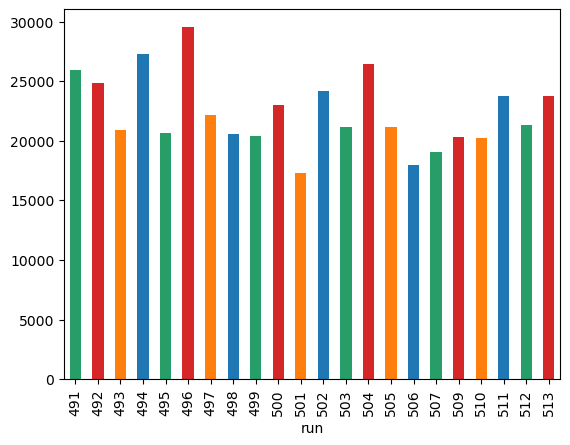

In [18]:
sorted_runs = sorted(classification_data['run'].unique())

classification_data['run'].value_counts().reindex(sorted_runs).plot.bar(color=['#279e68', '#d62728', '#ff7f0e', '#1f77b4'])

## 2.2. Make tags unique

In [19]:
classification_data.head()

,final_call,RescuedStatus,cmo,tags,run
0,CMO309,Not_Resc,309,AAACCCAAGCTCAGAG-1,510
1,CMO310,Not_Resc,310,AAACCCAAGGAGCTGT-1,510
2,CMO312,Not_Resc,312,AAACCCAAGGCACAAC-1,510
3,CMO309,Not_Resc,309,AAACCCAAGGGTTGCA-1,510
4,CMO309,Not_Resc,309,AAACCCACAAGTGGAC-1,510


In [20]:
classification_data['unique_index'] = classification_data['tags'].astype(str) + '-' + classification_data['run'].astype(str)
classification_data = classification_data.set_index('unique_index')

In [21]:
if classification_data.index.name != 'unique_index':
    classification_data = classification_data.set_index('unique_index')

In [22]:
classification_data = classification_data.reset_index()

In [23]:
classification_data.head()

,unique_index,final_call,RescuedStatus,cmo,tags,run
0,AAACCCAAGCTCAGAG-1-510,CMO309,Not_Resc,309,AAACCCAAGCTCAGAG-1,510
1,AAACCCAAGGAGCTGT-1-510,CMO310,Not_Resc,310,AAACCCAAGGAGCTGT-1,510
2,AAACCCAAGGCACAAC-1-510,CMO312,Not_Resc,312,AAACCCAAGGCACAAC-1,510
3,AAACCCAAGGGTTGCA-1-510,CMO309,Not_Resc,309,AAACCCAAGGGTTGCA-1,510
4,AAACCCACAAGTGGAC-1-510,CMO309,Not_Resc,309,AAACCCACAAGTGGAC-1,510


In [24]:
if classification_data.index.duplicated().any():
    duplicate_count = classification_data.index.duplicated().sum()
    print(f"Warning: {duplicate_count} duplicate indices found in classification_data.")
    # classification_data = classification_data[~classification_data.index.duplicated(keep='first')]
    # classification_data = classification_data[~classification_data.index.duplicated(keep=False)]
    # print(f"Removed {duplicate_count} rows. New shape of classification_data: {classification_data.shape}")

# 3. Load Cell Multiplexing Oligo - Not used

| | CONDITION | CELL LINE | MIX Name | CMO |
|--|-----------|-----------|----------|-----|
| 0 | ESTROGEN AGONIST | CTL04E | MIX 1 | 301 |
| 1 | ESTROGEN AGONIST | CTL04E | MIX 1 | 302 |
| 2 | ESTROGEN AGONIST | CTL04E | MIX 1 | 303 |
| 3 | ESTROGEN AGONIST | CTL08A | MIX 1 | 304 |
| 4 | ESTROGEN AGONIST | CTL08A | MIX 1 | 305 |

In [25]:
cmo_file_path = os.path.join(cmo_dir, "single_cell_CMO_sheet.xlsx")

cmo_mapping = pd.read_excel(cmo_file_path)
cmo_mapping['CMO'] = pd.to_numeric(cmo_mapping['CMO'], errors='coerce').astype('Int64')

In [26]:
cmo_mapping.head()

,CONDITION,CELL LINE,MIX Name,CMO
0,ESTROGEN AGONIST,CTL04E,MIX 1,301
1,ESTROGEN AGONIST,CTL04E,MIX 1,302
2,ESTROGEN AGONIST,CTL04E,MIX 1,303
3,ESTROGEN AGONIST,CTL08A,MIX 1,304
4,ESTROGEN AGONIST,CTL08A,MIX 1,305


In [27]:
cmo_mapping["MIX Name"].unique()
cmo_mapping["CMO"].unique()

<IntegerArray>
[301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, <NA>]
Length: 13, dtype: Int64

# 4. Load Metadata  

In [28]:
all_data = []

# Find all run directories
meta_dirs = glob.glob(os.path.join(meta_dir, 'input-run-MTR_*.csv'))
print(sorted([file.split('/')[-1].split('-')[-1] for file in meta_dirs]))

['MTR_491.csv', 'MTR_492.csv', 'MTR_493.csv', 'MTR_494.csv', 'MTR_495.csv', 'MTR_496.csv', 'MTR_497.csv', 'MTR_498.csv', 'MTR_499.csv', 'MTR_500.csv', 'MTR_501.csv', 'MTR_502.csv', 'MTR_503.csv', 'MTR_504.csv', 'MTR_505.csv', 'MTR_506.csv', 'MTR_507.csv', 'MTR_508.csv', 'MTR_509.csv', 'MTR_510.csv', 'MTR_511.csv', 'MTR_512.csv', 'MTR_513.csv']


In [30]:
import pandas as pd

run_condition = pd.DataFrame(columns=["run", "condition", "line", "replicate", "cmo"])

for meta_dir in meta_dirs:
    print(f"Processing file: {meta_dir}")
    run = meta_dir.split('_')[-1].split('.')[0]
    print(f"Run: {run}")

    # Read metadata and extract condition
    meta_data = extract_condition_type(meta_dir)
    print(f"Meta data: {meta_data}")

    # Ensure meta_data is a list of lists
    if isinstance(meta_data[0], str):
        conditions, lines, replicates, cmos = [meta_data[0]], [meta_data[1]], [meta_data[2]], [meta_data[3]]
    else:
        conditions, lines, replicates, cmos = meta_data
    
    if not conditions:
        print("Warning: No condition per run")
        continue
    elif len(list(dict.fromkeys(conditions))) > 1:
        print("Warning: More than one condition per run")
        conditions = [None] * len(conditions)

    for c, l, r, cm in zip(conditions, lines, replicates, cmos):
        new_row = pd.DataFrame({"run": [run], "condition": [c], "line": [l], "replicate": [r], "cmo": [cm]})
        run_condition = pd.concat([run_condition, new_row], ignore_index=True)

print(run_condition)

Processing file: /group/testa/Project/EndPoints/2024_singleCell/nextflow/output/cellranger-multi/input-run-MTR_493.csv
Run: 493
Meta data: [['ANDROGEN_AGONIST', 'ANDROGEN_AGONIST', 'ANDROGEN_AGONIST', 'ANDROGEN_AGONIST', 'ANDROGEN_AGONIST', 'ANDROGEN_AGONIST'], ['CTL04E', 'CTL04E', 'CTL04E', 'CTL08A', 'CTL08A', 'CTL08A'], ['1', '2', '3', '1', '2', '3'], ['CMO301', 'CMO302', 'CMO303', 'CMO304', 'CMO305', 'CMO306']]
Processing file: /group/testa/Project/EndPoints/2024_singleCell/nextflow/output/cellranger-multi/input-run-MTR_507.csv
Run: 507
Meta data: [['MEP', 'MEP', 'MEP', 'MEP', 'MEP', 'MEP'], ['CTL04E', 'CTL04E', 'CTL04E', 'CTL08A', 'CTL08A', 'CTL08A'], ['1', '2', '3', '1', '2', '3'], ['CMO301', 'CMO302', 'CMO303', 'CMO304', 'CMO305', 'CMO306']]
Processing file: /group/testa/Project/EndPoints/2024_singleCell/nextflow/output/cellranger-multi/input-run-MTR_491.csv
Run: 491
Meta data: [['ESTROGEN_AGONIST', 'ESTROGEN_AGONIST', 'ESTROGEN_AGONIST', 'ESTROGEN_AGONIST', 'ESTROGEN_AGONIST', '

In [31]:
run_condition.head()

,run,condition,line,replicate,cmo
0,493,ANDROGEN_AGONIST,CTL04E,1,CMO301
1,493,ANDROGEN_AGONIST,CTL04E,2,CMO302
2,493,ANDROGEN_AGONIST,CTL04E,3,CMO303
3,493,ANDROGEN_AGONIST,CTL08A,1,CMO304
4,493,ANDROGEN_AGONIST,CTL08A,2,CMO305


In [32]:
run_condition['cmo'] = run_condition['cmo'].str.extract('(\d+)').astype(int)

In [33]:
run_condition.head()

,run,condition,line,replicate,cmo
0,493,ANDROGEN_AGONIST,CTL04E,1,301
1,493,ANDROGEN_AGONIST,CTL04E,2,302
2,493,ANDROGEN_AGONIST,CTL04E,3,303
3,493,ANDROGEN_AGONIST,CTL08A,1,304
4,493,ANDROGEN_AGONIST,CTL08A,2,305


In [34]:
run_condition.isnull().values.any()

False

In [35]:
print(sorted(run_condition.run.unique()))

['491', '492', '493', '494', '495', '496', '497', '498', '499', '500', '501', '502', '503', '504', '505', '506', '507', '509', '510', '511', '512', '513']


In [36]:
run_condition.shape

(132, 5)

In [37]:
run_condition['run'] = pd.to_numeric(run_condition['run'], errors='coerce').astype('Int64')

In [38]:
extracted_runs = sorted(list(run_condition.run.unique()))
valid_range = list(range(491, 514))

missing_runs = [run for run in valid_range if run not in extracted_runs]
print(f"Missing runs: {missing_runs}")

Missing runs: [508]


# 5. Check Classification-Metadata Consistency

In [39]:
classification_data['cmo'] = classification_data['cmo'].astype(int)
run_condition['cmo'] = run_condition['cmo'].astype(int)

classification_data['run'] = classification_data['run'].astype(int)
run_condition['run'] = run_condition['run'].astype(int)

In [40]:
# Create lists of tuples from run_condition and classification_data
run_condition_list = list(run_condition[['run', 'cmo']].itertuples(index=False, name=None))
classification_data_list = list(classification_data[['run', 'cmo']].itertuples(index=False, name=None))

# Find inconsistencies using a list comprehension
inconsistencies = [item for item in classification_data_list if item not in run_condition_list]

In [41]:
if inconsistencies:
    print("Inconsistencies found:")
    for inc in inconsistencies:
        print(f"run: {inc[0]}, CMO: {inc[1]}, Condition: {inc[2]}, Cell Line: {inc[3]}")
else:
    print("No inconsistencies found. All triples are consistent between the dataframes.")

No inconsistencies found. All triples are consistent between the dataframes.


In [42]:
# Check for non-unique pairs in run_condition
run_condition_duplicates = run_condition[run_condition[['run', 'cmo']].duplicated()]
if not run_condition_duplicates.empty:
    print("\nNon-unique pairs found in run_condition:")
    print(run_condition_duplicates)
else:
    print("\nAll pairs in run_condition are unique.")


All pairs in run_condition are unique.


In [43]:
# Additional check: pairs in classification_data not in run_condition
missing_pairs = [item for item in classification_data_list if item not in run_condition_list]
if missing_pairs:
    print("\nPairs in classification_data not found in run_condition:")
    for pair in missing_pairs:
        print(f"Run: {pair[0]}, CMO: {pair[1]}")
else:
    print("\nAll pairs in classification_data are present in run_condition.")

# Additional check: pairs in run_condition not in classification_data
extra_pairs = [item for item in run_condition_list if item not in classification_data_list]
if extra_pairs:
    print("\nPairs in run_condition not found in classification_data:")
    for pair in extra_pairs:
        print(f"Run: {pair[0]}, CMO: {pair[1]}")
else:
    print("\nAll pairs in run_condition are present in classification_data.")


All pairs in classification_data are present in run_condition.

Pairs in run_condition not found in classification_data:
Run: 509, CMO: 305


In [44]:
extra_pairs

[(509, 305)]

In [45]:
print([item for item in run_condition_list if item not in classification_data_list])

[(509, 305)]


In [46]:
print(run_condition.shape)
run_condition = run_condition[~((run_condition.run == 509) & (run_condition.cmo == 305))]
print(run_condition.shape)

(132, 5)
(131, 5)


# 6. Combine Meta data

In [47]:
run_condition['run_cmo'] = run_condition['run'].astype(str) + run_condition['cmo'].astype(str)
classification_data['run_cmo'] = classification_data['run'].astype(str) + classification_data['cmo'].astype(str)

In [48]:
run_condition.head()

,run,condition,line,replicate,cmo,run_cmo
0,493,ANDROGEN_AGONIST,CTL04E,1,301,493301
1,493,ANDROGEN_AGONIST,CTL04E,2,302,493302
2,493,ANDROGEN_AGONIST,CTL04E,3,303,493303
3,493,ANDROGEN_AGONIST,CTL08A,1,304,493304
4,493,ANDROGEN_AGONIST,CTL08A,2,305,493305


In [49]:
classification_data.head()

,unique_index,final_call,RescuedStatus,cmo,tags,run,run_cmo
0,AAACCCAAGCTCAGAG-1-510,CMO309,Not_Resc,309,AAACCCAAGCTCAGAG-1,510,510309
1,AAACCCAAGGAGCTGT-1-510,CMO310,Not_Resc,310,AAACCCAAGGAGCTGT-1,510,510310
2,AAACCCAAGGCACAAC-1-510,CMO312,Not_Resc,312,AAACCCAAGGCACAAC-1,510,510312
3,AAACCCAAGGGTTGCA-1-510,CMO309,Not_Resc,309,AAACCCAAGGGTTGCA-1,510,510309
4,AAACCCACAAGTGGAC-1-510,CMO309,Not_Resc,309,AAACCCACAAGTGGAC-1,510,510309


In [50]:
classification_data['run_cmo'] = classification_data['run_cmo'].astype(int)
run_condition['run_cmo'] = run_condition['run_cmo'].astype(int)

In [51]:
classification_data_combined = classification_data.merge(
    run_condition[['run_cmo', 'condition', 'line', 'replicate']],
    on='run_cmo',
    how='left'
)

In [52]:
classification_data_combined.shape

(492061, 10)

In [53]:
classification_data_combined.head()

,unique_index,final_call,RescuedStatus,cmo,tags,run,run_cmo,condition,line,replicate
0,AAACCCAAGCTCAGAG-1-510,CMO309,Not_Resc,309,AAACCCAAGCTCAGAG-1,510,510309,BPF,CTL04E,3
1,AAACCCAAGGAGCTGT-1-510,CMO310,Not_Resc,310,AAACCCAAGGAGCTGT-1,510,510310,BPF,CTL08A,1
2,AAACCCAAGGCACAAC-1-510,CMO312,Not_Resc,312,AAACCCAAGGCACAAC-1,510,510312,BPF,CTL08A,3
3,AAACCCAAGGGTTGCA-1-510,CMO309,Not_Resc,309,AAACCCAAGGGTTGCA-1,510,510309,BPF,CTL04E,3
4,AAACCCACAAGTGGAC-1-510,CMO309,Not_Resc,309,AAACCCACAAGTGGAC-1,510,510309,BPF,CTL04E,3


In [54]:
# Check for any rows where the merge didn't find a match
unmatched_rows = classification_data_combined[classification_data_combined['condition'].isna()]

if not unmatched_rows.empty:
    print("Warning: Some rows in classification_data_combined didn't find a match in run_condition:")
    print(unmatched_rows[['run', 'cmo']])
else:
    print("All rows in classification_data_combined found a match in run_condition.")

All rows in classification_data_combined found a match in run_condition.


In [55]:
classification_data = classification_data_combined

# 7. Load Expression data - matrix.h5ad

In [56]:
data_dir

'/group/testa/Project/EndPoints/2024_singleCell/nextflow/output/cellranger-multi/filtered_matrix'

In [57]:
all_data = []

# Find all run directories
run_dirs = glob.glob(os.path.join(data_dir, 'run-MTR_*'))

In [58]:
runs = [run_dir.split('/')[-1].split('_')[-1] for run_dir in run_dirs]
print(sorted(runs))

['491', '492', '493', '494', '495', '496', '497', '498', '499', '500', '501', '502', '503', '504', '505', '506', '507', '509', '510', '511', '512', '513']


In [59]:
all_data = process_runs(run_dirs)

Processed run: 501, Shape: (30472, 36601)
Processed run: 506, Shape: (33800, 36601)
Processed run: 505, Shape: (31503, 36601)
Processed run: 510, Shape: (34286, 36601)
Processed run: 512, Shape: (30454, 36601)
Processed run: 498, Shape: (27504, 36601)
Processed run: 499, Shape: (37685, 36601)
Processed run: 497, Shape: (35626, 36601)
Processed run: 509, Shape: (38982, 36601)Processed run: 503, Shape: (38015, 36601)Processed run: 513, Shape: (35133, 36601)

Processed run: 511, Shape: (34897, 36601)Processed run: 491, Shape: (35618, 36601)Processed run: 495, Shape: (36867, 36601)



Processed run: 493, Shape: (38899, 36601)
Processed run: 502, Shape: (41429, 36601)
Processed run: 500, Shape: (43971, 36601)Processed run: 507, Shape: (36806, 36601)

Processed run: 492, Shape: (39679, 36601)Processed run: 494, Shape: (42089, 36601)Processed run: 504, Shape: (42043, 36601)


Processed run: 496, Shape: (42509, 36601)
Number of processed runs: 22


In [61]:
# Concatenate all data
combined_data = ad.concat(all_data, join='outer')

# Make observation names unique in the combined dataset
combined_data.var_names_make_unique()
combined_data.obs_names_make_unique()

In [62]:
combined_data.obs.head()

,tags,run
index,,
AAACCCAAGAAACCCG-1-501,AAACCCAAGAAACCCG-1,501
AAACCCAAGAACTGAT-1-501,AAACCCAAGAACTGAT-1,501
AAACCCAAGCCTGTGC-1-501,AAACCCAAGCCTGTGC-1,501
AAACCCAAGCGATGAC-1-501,AAACCCAAGCGATGAC-1,501
AAACCCAAGCGCCGTT-1-501,AAACCCAAGCGCCGTT-1,501


In [63]:
combined_data.obs['run'] = combined_data.obs['run'].astype(int)

In [64]:
combined_data.write_h5ad(os.path.join(output_dir, 'combined_raw_scRNA_seq_data.h5ad'))

In [65]:
# combined_data = ad.read_h5ad(os.path.join(output_dir, 'combined_raw_scRNA_seq_data.h5ad'))

In [66]:
# identify and remove duplicated tags
duplicate_obs = combined_data.obs_names.duplicated(keep=False)
duplicate_count = duplicate_obs.sum()
print(f"Number of duplicate observations: {duplicate_count}")

Number of duplicate observations: 0


In [67]:
# Remove duplicate observations
# combined_data = combined_data[~duplicate_obs].copy()

# 8. Add Metadata to the Expression data

In [68]:
combined_data.obs.head()

,tags,run
index,,
AAACCCAAGAAACCCG-1-501,AAACCCAAGAAACCCG-1,501
AAACCCAAGAACTGAT-1-501,AAACCCAAGAACTGAT-1,501
AAACCCAAGCCTGTGC-1-501,AAACCCAAGCCTGTGC-1,501
AAACCCAAGCGATGAC-1-501,AAACCCAAGCGATGAC-1,501
AAACCCAAGCGCCGTT-1-501,AAACCCAAGCGCCGTT-1,501


In [69]:
classification_data.head()


,unique_index,final_call,RescuedStatus,cmo,tags,run,run_cmo,condition,line,replicate
0,AAACCCAAGCTCAGAG-1-510,CMO309,Not_Resc,309,AAACCCAAGCTCAGAG-1,510,510309,BPF,CTL04E,3
1,AAACCCAAGGAGCTGT-1-510,CMO310,Not_Resc,310,AAACCCAAGGAGCTGT-1,510,510310,BPF,CTL08A,1
2,AAACCCAAGGCACAAC-1-510,CMO312,Not_Resc,312,AAACCCAAGGCACAAC-1,510,510312,BPF,CTL08A,3
3,AAACCCAAGGGTTGCA-1-510,CMO309,Not_Resc,309,AAACCCAAGGGTTGCA-1,510,510309,BPF,CTL04E,3
4,AAACCCACAAGTGGAC-1-510,CMO309,Not_Resc,309,AAACCCACAAGTGGAC-1,510,510309,BPF,CTL04E,3


In [70]:
classification_data = classification_data.set_index('unique_index')

In [71]:
combined_data.obs_names[:5]

Index(['AAACCCAAGAAACCCG-1-501', 'AAACCCAAGAACTGAT-1-501',
       'AAACCCAAGCCTGTGC-1-501', 'AAACCCAAGCGATGAC-1-501',
       'AAACCCAAGCGCCGTT-1-501'],
      dtype='object', name='index')

In [72]:
print(classification_data.index[:5])
print(combined_data.obs.index[:5])

Index(['AAACCCAAGCTCAGAG-1-510', 'AAACCCAAGGAGCTGT-1-510',
       'AAACCCAAGGCACAAC-1-510', 'AAACCCAAGGGTTGCA-1-510',
       'AAACCCACAAGTGGAC-1-510'],
      dtype='object', name='unique_index')
Index(['AAACCCAAGAAACCCG-1-501', 'AAACCCAAGAACTGAT-1-501',
       'AAACCCAAGCCTGTGC-1-501', 'AAACCCAAGCGATGAC-1-501',
       'AAACCCAAGCGCCGTT-1-501'],
      dtype='object', name='index')


In [73]:
new_obs_data = pd.DataFrame(index=combined_data.obs_names)

In [74]:
columns_to_add = ['cmo', 'run', 'condition', 'line', 'replicate']
for col in columns_to_add:
    new_obs_data[col] = classification_data.loc[classification_data.index.intersection(new_obs_data.index), col]

In [75]:
for col in columns_to_add:
    combined_data.obs[col] = new_obs_data[col]

In [76]:
combined_data.obs.head()

,tags,run,cmo,condition,line,replicate
index,,,,,,
AAACCCAAGAAACCCG-1-501,AAACCCAAGAAACCCG-1,501.0,303.0,THYROID_AGONIST,CTL04E,3
AAACCCAAGAACTGAT-1-501,AAACCCAAGAACTGAT-1,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCCTGTGC-1-501,AAACCCAAGCCTGTGC-1,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCGATGAC-1-501,AAACCCAAGCGATGAC-1,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCGCCGTT-1-501,AAACCCAAGCGCCGTT-1,NaN,NaN,NaN,NaN,NaN


In [77]:
unmatched_cells = new_obs_data[new_obs_data.isnull().any(axis=1)]
if not unmatched_cells.empty:
    print(f"Warning: {len(unmatched_cells)} cells in combined_data.obs didn't find a match in processed_data_combined")
    print("First few unmatched cells:")
    print(unmatched_cells.head())
else:
    print("All cells in combined_data.obs found a match in processed_data_combined")

First few unmatched cells:
                        cmo  run condition line replicate
index                                                    
AAACCCAAGAACTGAT-1-501  NaN  NaN       NaN  NaN       NaN
AAACCCAAGCCTGTGC-1-501  NaN  NaN       NaN  NaN       NaN
AAACCCAAGCGATGAC-1-501  NaN  NaN       NaN  NaN       NaN
AAACCCAAGCGCCGTT-1-501  NaN  NaN       NaN  NaN       NaN
AAACCCAAGTACGAGC-1-501  NaN  NaN       NaN  NaN       NaN


In [78]:
print(f"Number of cells before removing unmapped and duplicates: {combined_data.n_obs}")

mapped_cells_mask = combined_data.obs[['cmo', 'run', 'condition', 'line', 'replicate']].notna().all(axis=1)

unmapped_cells = (~mapped_cells_mask).sum()
print(f"Number of unmapped cells to be removed: {unmapped_cells}")

combined_data = combined_data[mapped_cells_mask]

Number of cells before removing unmapped and duplicates: 808267
Number of unmapped cells to be removed: 316206


In [79]:
# Check if there are any remaining NaN values
if combined_data.obs[['cmo', 'run', 'condition', 'line', 'replicate']].isna().any().any():
    print("Warning: There are still some NaN values in the mapped columns.")
else:
    print("All remaining cells are fully mapped with no NaN values.")

# Check if there are any remaining duplicates
if combined_data.obs_names.duplicated().any():
    print("Warning: There are still some duplicate observation names.")
else:
    print("All observation names are now unique.")

All remaining cells are fully mapped with no NaN values.
All observation names are now unique.


In [80]:
combined_data.shape

(492061, 36601)

<Axes: xlabel='run'>

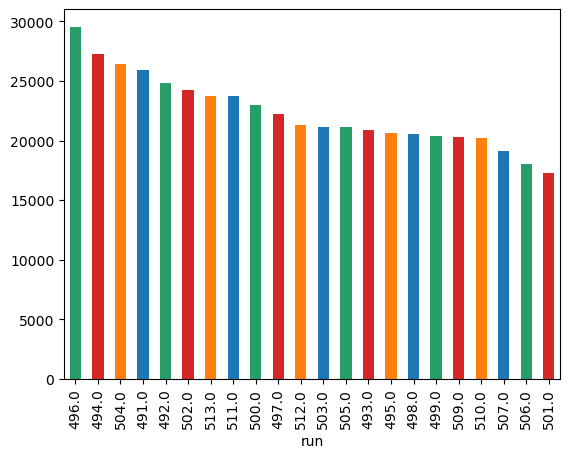

In [81]:
combined_data.obs['run'].value_counts().plot.bar(color=['#279e68', '#d62728', '#ff7f0e', '#1f77b4'])

In [82]:
dir_508 = "/group/testa/Project/EndPoints/2024_singleCell/nextflow/output/cellranger-multi/run-MTR_508/per_sample_outs/tmp-MTR_508/count"
adata = sc.read_10x_h5(os.path.join(dir_508, 'sample_filtered_feature_bc_matrix.h5'))
adata.obs["run"] = 508
adata.obs["condition"] = "RET_AGONIST"
adata.obs = adata.obs.reset_index().rename(columns={'index': 'tags'})
adata.obs['index'] = adata.obs['tags'].astype(str) + '-' + adata.obs['run'].astype(str)
adata.obs.set_index('index', inplace=True)
adata.var_names_make_unique()
adata.obs_names_make_unique()

print(f"Existing combined data shape: {combined_data.shape}")
print(f"Additional data shape: {adata.shape}")

/home/michal.kubacki/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Existing combined data shape: (492061, 36601)
Additional data shape: (38652, 36601)


/home/michal.kubacki/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [83]:
try:
    updated_combined_data = ad.concat(
        [combined_data, adata], 
        join='outer', 
        merge='first'
    )
    print(f"Updated combined data shape: {updated_combined_data.shape}")
except Exception as e:
    print(f"Error during data combination: {str(e)}")

Updated combined data shape: (530713, 36601)


In [84]:
combined_data = updated_combined_data

In [85]:
combined_data.write_h5ad(os.path.join(output_dir, 'combined_scRNA_seq_data.h5ad'))

In [86]:
combined_data = ad.read_h5ad(os.path.join(output_dir, 'combined_scRNA_seq_data.h5ad'))

In [87]:
combined_data.obs.head()

,tags,run,cmo,condition,line,replicate
index,,,,,,
AAACCCAAGAAACCCG-1-501,AAACCCAAGAAACCCG-1,501.0,303.0,THYROID_AGONIST,CTL04E,3
AAACCCAAGGACGCAT-1-501,AAACCCAAGGACGCAT-1,501.0,306.0,THYROID_AGONIST,CTL08A,3
AAACCCAAGTTGAAAC-1-501,AAACCCAAGTTGAAAC-1,501.0,305.0,THYROID_AGONIST,CTL08A,2
AAACCCACAACGGGTA-1-501,AAACCCACAACGGGTA-1,501.0,306.0,THYROID_AGONIST,CTL08A,3
AAACCCACAAGATCCT-1-501,AAACCCACAAGATCCT-1,501.0,303.0,THYROID_AGONIST,CTL04E,3


In [88]:
import pandas as pd
import numpy as np

print("Current categories:", combined_data.obs['condition'].cat.categories)
print("Number of NaN values:", combined_data.obs['condition'].isna().sum())

# Get the current categories and add 'Unknown'
current_categories = combined_data.obs['condition'].cat.categories.tolist()
if 'Unknown' not in current_categories:
    current_categories.append('Unknown')

# Create a new categorical column with 'Unknown' included in categories
combined_data.obs['condition_clean'] = pd.Categorical(
    combined_data.obs['condition'].astype(str).replace('nan', 'Unknown'),
    categories=current_categories
)

condition_strings = combined_data.obs['condition_clean'].astype(str)

# Get all unique conditions
all_conditions = condition_strings.unique()

# Convert to a list and sort alphabetically
sorted_conditions = sorted(list(all_conditions))

# Print the sorted conditions
print("Conditions in alphabetical order:")
for condition in sorted_conditions:
    print(condition)

Current categories: Index(['3-PBA', 'ANDROGEN_AGONIST', 'ANDROGEN_ANTAGONIST', 'ARYL_HYD_AGONIST',
       'ARYL_HYD_ANTAGONIST', 'BPA', 'BPF', 'DMSO', 'DPHP', 'ESTROGEN_AGONIST',
       'ESTROGEN_ANTAGONIST', 'GLUCOCORT_AGONIST', 'GLUCOCORT_ANTAGONIST',
       'LIVER-X_AGONIST', 'LIVER-X_ANTAGONIST', 'MBzP', 'MEP', 'MIX',
       'RET_AGONIST', 'RET_ANTAGONIST', 'TCP', 'THYROID_AGONIST',
       'THYROID_ANTAGONIST'],
      dtype='object')
Number of NaN values: 0
Conditions in alphabetical order:
3-PBA
ANDROGEN_AGONIST
ANDROGEN_ANTAGONIST
ARYL_HYD_AGONIST
ARYL_HYD_ANTAGONIST
BPA
BPF
DMSO
DPHP
ESTROGEN_AGONIST
ESTROGEN_ANTAGONIST
GLUCOCORT_AGONIST
GLUCOCORT_ANTAGONIST
LIVER-X_AGONIST
LIVER-X_ANTAGONIST
MBzP
MEP
MIX
RET_AGONIST
RET_ANTAGONIST
TCP
THYROID_AGONIST
THYROID_ANTAGONIST


# 9. Add 393 runs (only gentic multiplexed)

In [92]:
data_dirs = {
    "MTR_393_3GEX" : "/group/testa/Project/EndPoints/2024_singleCell/nextflow_RITM0022624/outputs_count/MTR_393_3GEX/outs",
    "MTR_394_3GEX" : "/group/testa/Project/EndPoints/2024_singleCell/nextflow_RITM0022624/outputs_count/MTR_394_3GEX/outs"
}

In [93]:
all_data = []

for key, data_dir in data_dirs.items():
    print(f"Loading {key}")
    file_path = os.path.join(data_dir, 'filtered_feature_bc_matrix.h5')
    adata = sc.read_10x_h5(file_path)
    adata.obs["condition"] = key
    adata.obs["run"] = key.split('_')[1]
    adata.obs = adata.obs.reset_index()
    adata.obs = adata.obs.rename(columns={'index': 'tags'})
    adata.obs['index'] = adata.obs['tags'].astype(str) + '-' + adata.obs['run'].astype(str)
    adata.obs = adata.obs.set_index('index')
    adata.obs = adata.obs.rename_axis(None)
    adata.obs_names_make_unique()
    adata.var_names_make_unique()
    print(adata.obs.head())

    n_cells, n_genes = adata.shape
    print(f"Number of cells: {n_cells}")
    print(f"Number of genes: {n_genes}")
    all_data.append(adata)

Loading MTR_393_3GEX


/home/michal.kubacki/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/michal.kubacki/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


                                      tags     condition  run
AAACCCAAGACCAAAT-1-393  AAACCCAAGACCAAAT-1  MTR_393_3GEX  393
AAACCCAAGACCCTTA-1-393  AAACCCAAGACCCTTA-1  MTR_393_3GEX  393
AAACCCAAGCAAGGAA-1-393  AAACCCAAGCAAGGAA-1  MTR_393_3GEX  393
AAACCCAAGCACTCAT-1-393  AAACCCAAGCACTCAT-1  MTR_393_3GEX  393
AAACCCAAGCCTGCCA-1-393  AAACCCAAGCCTGCCA-1  MTR_393_3GEX  393
Number of cells: 37830
Number of genes: 36601
Loading MTR_394_3GEX


/home/michal.kubacki/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


                                      tags     condition  run
AAACCCAAGACGGAAA-1-394  AAACCCAAGACGGAAA-1  MTR_394_3GEX  394
AAACCCAAGAGGGTGG-1-394  AAACCCAAGAGGGTGG-1  MTR_394_3GEX  394
AAACCCAAGATACCAA-1-394  AAACCCAAGATACCAA-1  MTR_394_3GEX  394
AAACCCAAGCCTGTCG-1-394  AAACCCAAGCCTGTCG-1  MTR_394_3GEX  394
AAACCCAAGCGCCCAT-1-394  AAACCCAAGCGCCCAT-1  MTR_394_3GEX  394
Number of cells: 53030
Number of genes: 36601


/home/michal.kubacki/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [94]:
# Concatenate all data
to_add_combined = ad.concat(all_data, join='outer')

In [95]:
to_add_combined.obs.head()

,tags,condition,run
AAACCCAAGACCAAAT-1-393,AAACCCAAGACCAAAT-1,MTR_393_3GEX,393
AAACCCAAGACCCTTA-1-393,AAACCCAAGACCCTTA-1,MTR_393_3GEX,393
AAACCCAAGCAAGGAA-1-393,AAACCCAAGCAAGGAA-1,MTR_393_3GEX,393
AAACCCAAGCACTCAT-1-393,AAACCCAAGCACTCAT-1,MTR_393_3GEX,393
AAACCCAAGCCTGCCA-1-393,AAACCCAAGCCTGCCA-1,MTR_393_3GEX,393


In [96]:
combined_data.obs.head()

,tags,run,cmo,condition,line,replicate,condition_clean
index,,,,,,,
AAACCCAAGAAACCCG-1-501,AAACCCAAGAAACCCG-1,501.0,303.0,THYROID_AGONIST,CTL04E,3,THYROID_AGONIST
AAACCCAAGGACGCAT-1-501,AAACCCAAGGACGCAT-1,501.0,306.0,THYROID_AGONIST,CTL08A,3,THYROID_AGONIST
AAACCCAAGTTGAAAC-1-501,AAACCCAAGTTGAAAC-1,501.0,305.0,THYROID_AGONIST,CTL08A,2,THYROID_AGONIST
AAACCCACAACGGGTA-1-501,AAACCCACAACGGGTA-1,501.0,306.0,THYROID_AGONIST,CTL08A,3,THYROID_AGONIST
AAACCCACAAGATCCT-1-501,AAACCCACAAGATCCT-1,501.0,303.0,THYROID_AGONIST,CTL04E,3,THYROID_AGONIST


In [97]:
combined = ad.concat([combined_data, to_add_combined], join='outer', merge='first')

In [98]:
combined

AnnData object with n_obs × n_vars = 621573 × 36601
    obs: 'tags', 'run', 'cmo', 'condition', 'line', 'replicate', 'condition_clean'
    var: 'gene_ids', 'feature_types', 'genome'

In [99]:
combined.obs.run = combined.obs.run.astype(int)
combined.obs.head()


,tags,run,cmo,condition,line,replicate,condition_clean
AAACCCAAGAAACCCG-1-501,AAACCCAAGAAACCCG-1,501,303.0,THYROID_AGONIST,CTL04E,3,THYROID_AGONIST
AAACCCAAGGACGCAT-1-501,AAACCCAAGGACGCAT-1,501,306.0,THYROID_AGONIST,CTL08A,3,THYROID_AGONIST
AAACCCAAGTTGAAAC-1-501,AAACCCAAGTTGAAAC-1,501,305.0,THYROID_AGONIST,CTL08A,2,THYROID_AGONIST
AAACCCACAACGGGTA-1-501,AAACCCACAACGGGTA-1,501,306.0,THYROID_AGONIST,CTL08A,3,THYROID_AGONIST
AAACCCACAAGATCCT-1-501,AAACCCACAAGATCCT-1,501,303.0,THYROID_AGONIST,CTL04E,3,THYROID_AGONIST


In [100]:
combined.obs[combined.obs.run.isin([393, 394])].head()

,tags,run,cmo,condition,line,replicate,condition_clean
AAACCCAAGACCAAAT-1-393,AAACCCAAGACCAAAT-1,393,NaN,MTR_393_3GEX,NaN,NaN,NaN
AAACCCAAGACCCTTA-1-393,AAACCCAAGACCCTTA-1,393,NaN,MTR_393_3GEX,NaN,NaN,NaN
AAACCCAAGCAAGGAA-1-393,AAACCCAAGCAAGGAA-1,393,NaN,MTR_393_3GEX,NaN,NaN,NaN
AAACCCAAGCACTCAT-1-393,AAACCCAAGCACTCAT-1,393,NaN,MTR_393_3GEX,NaN,NaN,NaN
AAACCCAAGCCTGCCA-1-393,AAACCCAAGCCTGCCA-1,393,NaN,MTR_393_3GEX,NaN,NaN,NaN


<Axes: xlabel='run'>

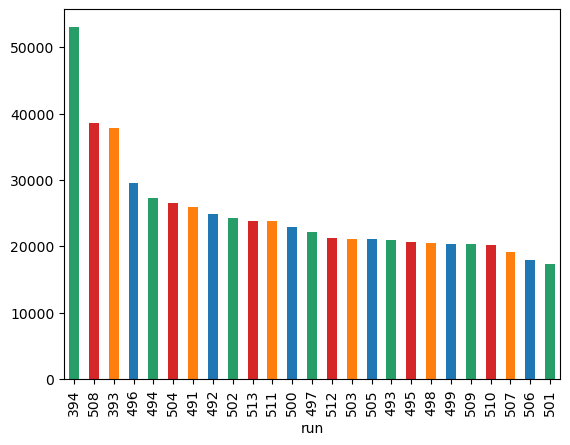

In [101]:
combined.obs['run'].value_counts().plot.bar(color=['#279e68', '#d62728', '#ff7f0e', '#1f77b4'])

<Axes: xlabel='run'>

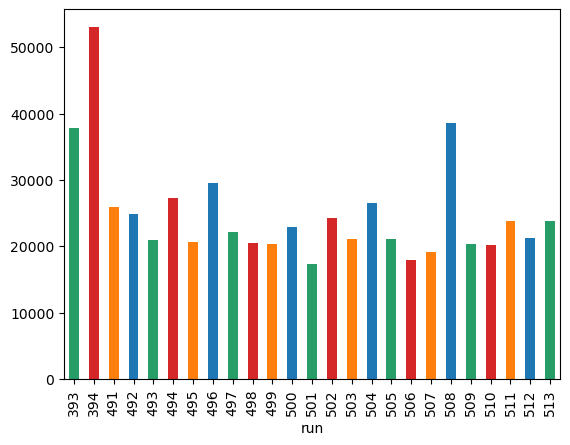

In [102]:
sorted_runs = sorted(combined.obs['run'].unique())

combined.obs['run'].value_counts().reindex(sorted_runs).plot.bar(color=['#279e68', '#d62728', '#ff7f0e', '#1f77b4'])

In [103]:
combined.write_h5ad(os.path.join(output_dir, 'combined_scRNA_seq_data_39X.h5ad'))

In [104]:
# Check if each run is assigned to only one condition
run_to_condition = combined.obs.groupby('run')['condition'].nunique()
single_condition_per_run = (run_to_condition == 1).all()

# Check if each condition is assigned to only one run
condition_to_run = combined.obs.groupby('condition')['run'].nunique()
single_run_per_condition = (condition_to_run == 1).all()

print(f"Each run is assigned to only one condition: {single_condition_per_run}")
print(f"Each condition is assigned to only one run: {single_run_per_condition}")

Each run is assigned to only one condition: True
Each condition is assigned to only one run: True


/localscratch/13399779.michal.kubacki/ipykernel_1007946/2822496074.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  condition_to_run = combined.obs.groupby('condition')['run'].nunique()


In [105]:
combined

AnnData object with n_obs × n_vars = 621573 × 36601
    obs: 'tags', 'run', 'cmo', 'condition', 'line', 'replicate', 'condition_clean'
    var: 'gene_ids', 'feature_types', 'genome'

# Legacy

In [ ]:
# for run_dir in run_dirs:
#     try:
#         print(f"Processing run: {run_dir}")
#         adata = sc.read_h5ad(os.path.join(run_dir, 'matrix.h5ad'))
#         adata.obs["run"] = run_dir.split('/')[-1].split('_')[-1]
#         adata.obs = adata.obs.reset_index()
#         adata.obs = adata.obs.rename(columns={'index': 'tags'})
#         adata.obs['index'] = adata.obs['tags'].astype(str) + '-' + adata.obs['run'].astype(str)
#         adata.obs = adata.obs.set_index('index')
#         adata.var_names_make_unique()
#         adata.obs_names_make_unique()
#         print(f"Loaded AnnData object: {adata.shape}")
#         all_data.append(adata)
#     except Exception as e:
#         print(f"Error processing {run_dir}: {str(e)}")

# print(f"Number of processed runs: {len(all_data)}")